# Import Necessary Libraries

In [2]:
import re
import pandas as pd
import numpy as np
import geopandas as gpd
from pyproj import Transformer, Geod
from shapely.geometry import Point, LineString, Polygon

# Data Loading
I came across consistent errors with loading the JSON files 'datasourceerror: failed to read esrijson data' and therefore decided to download the ARCGIS data (“Wildland Fire Polygons Fire Feature Data ArcGIS Pro 2.8 Geodatabase”) and load it using GeoPandas. 

Additionally, vector math is extremely easy out of the box using GeoPandas, so for the scope of this assignment, I will be using GeoPandas instead of GeoJSON

In [3]:
# The GeoDataBase format can be read using the geopandas read_file method
gdf = gpd.read_file('../Fire_Feature_Data.gdb/')
gdf.head()

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,Listed_Fire_Names,...,Wildfire_Notice,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,geometry
0,1,Wildfire,1860,1,1 (1),3940.207089,1594.545237,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),Big Quilcene River (1),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.047590,NaN,No,64888.449849,1.594545e+07,"MULTIPOLYGON (((-1883775.596 1194154.192, -188..."
1,2,Wildfire,1860,1,1 (1),772.518249,312.627044,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),Harrison Lake (1),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.071367,NaN,No,23462.288613,3.126270e+06,"MULTIPOLYGON (((-1887470.131 1187759.244, -188..."
2,3,Wildfire,1860,1,1 (1),333.020409,134.768578,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),Tunnel Creek (1),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.379578,NaN,No,6679.573569,1.347686e+06,"MULTIPOLYGON (((-1889386.119 1190683.928, -188..."
3,4,Wildfire,1870,1,"1 (1), 3 (1)",22294.993577,9022.463795,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (1)",1870 (2),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.158038,NaN,No,84700.719226,9.022464e+07,"MULTIPOLYGON (((-1428896.297 864980.034, -1428..."
4,5,Wildfire,1870,1,"1 (1), 3 (1)",36.985574,14.967531,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (1)",No Fire Name Provided (2),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.218009,NaN,No,2937.265383,1.496753e+05,"MULTIPOLYGON (((-1371410.414 595942.396, -1371..."


In [4]:
# We see there are 135K instances of fire in the dataset, this number should go down as we filter the data
gdf.shape

(135061, 30)

### Subset the data according to the analysis requirements

In [5]:
# Subset for year
gdf = gdf[gdf.Fire_Year > 1963]

### Analyze GIS data

It is important to check the CRS of the data to ensure that the unit for distances we aim to measure are inline with the data

In [6]:
gdf.crs

<Projected CRS: ESRI:102008>
Name: North_America_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

This CRS uses meters as it's unit of distance which is great. However, this project does not guarantee preservation of distances. 
Let's change the projection to one that preserves distances

In [7]:
# Change CRS to one that preserves distances
gdf = gdf.to_crs('ESRI:102005')

The following coordinate data has been taken from the [Yavapai County]((https://en.wikipedia.org/wiki/Yavapai_County,_Arizona)) page on Wikipedia

In [8]:
# Encode target country coodinates in NAD-83 style
# This is my county!
county_location = { 'yavapai': {'county': 'Yavapai Country', 'latlon' : [-112.54, 34.561389]}}

county_location_point = Point(county_location['yavapai']['latlon'])
county_location_point = gpd.GeoDataFrame({'geometry': [county_location_point]}, crs='4326')
county_location_point = county_location_point.to_crs(gdf.crs)

> Note: This part is particularly tricky. We set the CRS to 4326 when we define the point since we are using GPS coordinates, but change the CRS to match the fire data right after

In [9]:
county_location_point

,geometry
0,POINT (-1506022.835 -355637.409)


> We can see how the coordinates changed from -112.54, 34.561389

Once we have the coordinates of our county instantiated, we need to draw a 1250 mile radius around it to check which fires are relevant. We use the simple and out of the box buffer functionality of GeoPandas

In [10]:
buffer_length_in_meters = (1250 * 1609.34) # Miles to Meters conversion
county_location_buffer = county_location_point.buffer(buffer_length_in_meters)
county_location_buffer = gpd.GeoDataFrame(county_location_buffer).set_geometry(0)

Multipolygons can be pretty confusing. Looking at the dataframe and its values is practically useless, so let's visualise things to verify our approach.

<AxesSubplot: >

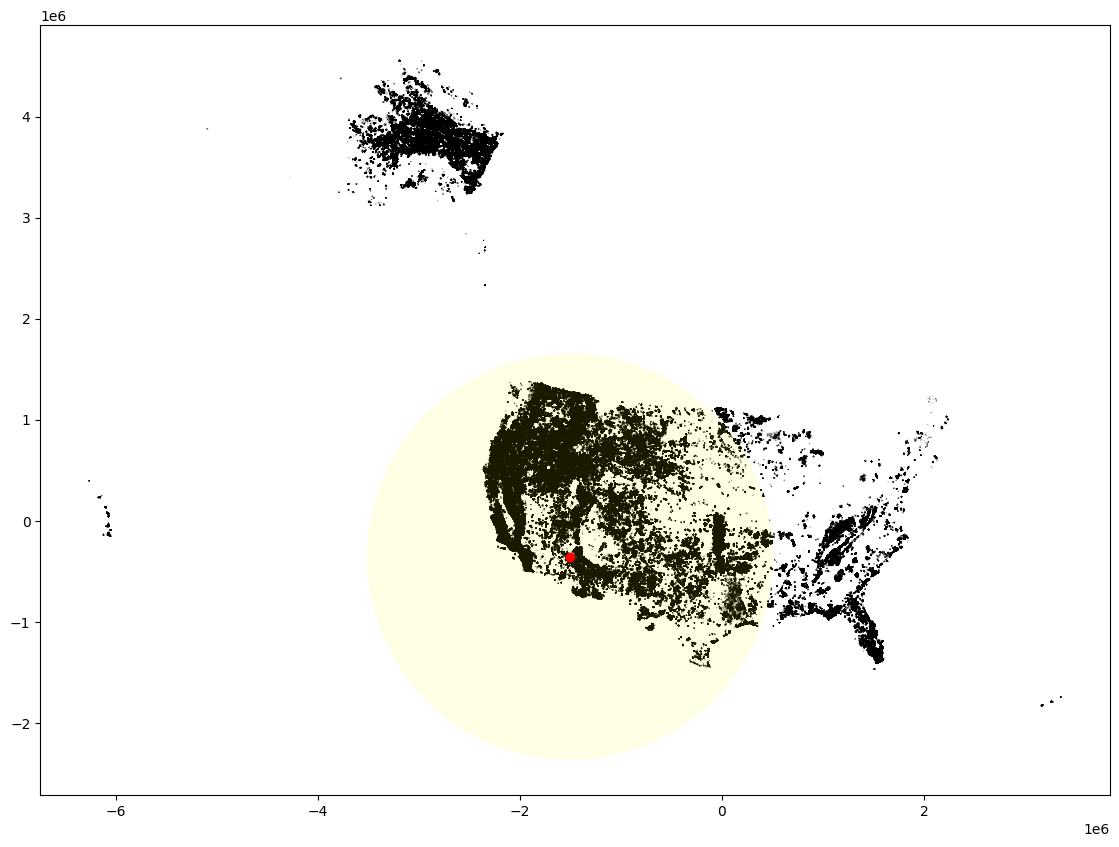

In [11]:
# TODO: Label plot
ax = gdf.plot(figsize=(16, 10), color='white', edgecolor='black')
county_location_buffer.plot(ax=ax, color='yellow', alpha=0.1)
county_location_point.plot(ax=ax, color='red', alpha=1)

We can see that the location of our country looks correct, and is at the centre of the cirle that encompasses 1250 miles.

Now let's find the intersection between the data for all us the US and our 1250 mile radius

### Subset by distance

In [12]:
# Let's ensure that we are in the same CRS
assert gdf.crs == county_location_buffer.crs

In [13]:
# Now we select the overlapping data to subset to a 1250 mile radius
gdf_subset = gpd.sjoin(gdf, county_location_buffer)

In [14]:
gdf_subset['Distance_To_County_miles'] = gdf_subset.geometry.apply(lambda x: x.distance(county_location_point).geometry*0.000621371)

### Smoke Impact Estimation
Let's identify some columns that we assume would impact the smoke levels in our city

In [15]:
# Select a subset of columns that might be of interest
columns_of_interest = ['USGS_Assigned_ID', 
                       'Assigned_Fire_Type', 
                       'Fire_Year', 
                       'GIS_Acres',
                       'Distance_To_County_miles']

In [16]:
df = gdf_subset[columns_of_interest]
df.head()

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Distance_To_County_miles
14599,14600,Wildfire,1964,65338.877636,394.787966
14600,14601,Wildfire,1964,55960.694158,615.719786
14601,14602,Wildfire,1964,19218.105903,273.839838
14602,14603,Wildfire,1964,18712.494746,701.033798
14603,14604,Wildfire,1964,16887.001024,747.486548


In [17]:
df.Assigned_Fire_Type.unique()

array(['Wildfire', 'Unknown - Likely Wildfire', 'Prescribed Fire',
       'Likely Wildfire', 'Unknown - Likely Prescribed Fire'],
      dtype=object)

Since this is an estimation exercise without a target label in mind, we are to assume how these features would impact the smoke levels. Going by gut feeling, this is my estimator:

    smoke_impact = 0.35*GIS_Acres + 0.55*1/Distance_To_County_miles + 0.10[Assigned_Fire_Type == 'Wildfire'] +  0.05[Assigned_Fire_Type == 'Prescribed Fire'] - 0.2

    smoke_impact = 1/(1+e^(-smoke_impact))

Since Assigned_Fire_Type is a categorical variable, we must break it down into multiple binary variables, which are true when Assigned_Fire_Type belongs to their category. 

The idea behind this rough estimate is simple: 
- The bigger the fire, the larger the impact
- The closer the fire, the larger the impact
- Wildfires will probably have more impact than a Prescribed Fire

I have additionally take a -0.2 bias term since our data only contributes to shifting the impact upwards. We will use a function that will keep the impact range between 0,1 so it's probably nice to have a term which brings the impact low. In any case, we won't see a fire have a negative impact on our estimate 

In [18]:
numerical_variables = ['GIS_Acres', 'Distance_To_County_miles']
df_normalized = (df[numerical_variables]-df[numerical_variables].min())/(df[numerical_variables].max()-df[numerical_variables].min())
df = df.join(df_normalized, rsuffix='_normalised')

In [58]:
# This is our estimator function. It follows the earlier prescribed formula
def estimator(df):
    value = 0.35*df['GIS_Acres'] + \
            0.55/df['Distance_To_County_miles'] + \
            0.10*(df.Assigned_Fire_Type == 'Wildfire') + \
            0.05*(df.Assigned_Fire_Type == 'Prescribed Fire') - 0.2
    
    value = 1/(1+np.exp(-value))
    return value

In [59]:
df['impact_estimate'] = estimator(df)

In [60]:
df = df.sort_values(by='Fire_Year')

### Forecast
Since are forecasting our own estimate, it makes sense to use an AutoRegressive model. An autoregressive model is a time series model where future values of a variable are linearly dependent on its past values. 

In [62]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

train_size = int(0.8 * len(df))
train_data = df.groupby('Fire_Year').sum()['impact_estimate'][:train_size]
test_data = df.groupby('Fire_Year').sum()['impact_estimate'][train_size:]

# Define the order of the ARIMA model (p, d, q)
p = 3  # Autoregressive order
d = 2  # Integration order (to make the time series stationary)
q = 3  # Moving average order

# Fit the ARIMA model
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# Make predictions for the next 25 time steps
forecast_values = model_fit.forecast(steps=28)

# Print the forecasted values
print(forecast_values)

57    3115.855443
58    3186.793567
59    3493.307596
60    3276.754431
61    3412.416922
62    3617.920741
63    3416.561895
64    3644.231382
65    3717.487132
66    3596.474699
67    3843.556364
68    3823.281651
69    3796.432311
70    4013.989229
71    3945.596315
72    4002.331571
73    4162.670466
74    4088.638791
75    4202.722713
76    4299.592909
77    4250.589329
78    4390.946406
79    4434.311982
80    4425.934481
81    4565.129946
82    4573.941107
83    4607.839445
84    4727.139108
Name: predicted_mean, dtype: float64


/var/folders/7l/7tynfbss6zx6wlvqs5gs9bnh0000gn/T/ipykernel_38468/2671200180.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_data = df.groupby('Fire_Year').sum()['impact_estimate'][:train_size]
/var/folders/7l/7tynfbss6zx6wlvqs5gs9bnh0000gn/T/ipykernel_38468/2671200180.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_data = df.groupby('Fire_Year').sum()['impact_estimate'][:train_size]
/var/folders/7l/7tynfbss6zx6wlvqs5gs9bnh0000gn/T/ipykernel_38468/2671200180.py:7: FutureWarning: The default value of numeric_only in DataFrameG

<AxesSubplot: >

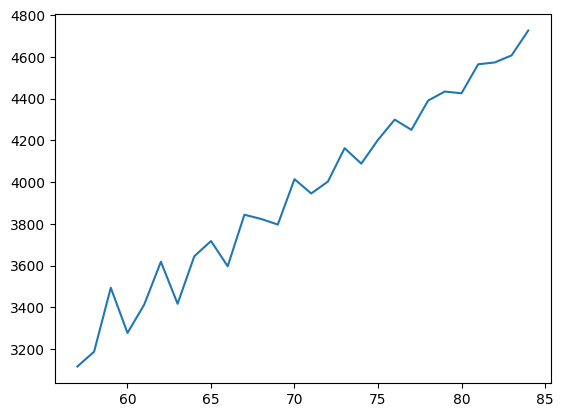

In [63]:
forecast_values.plot()

## Visualisation

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

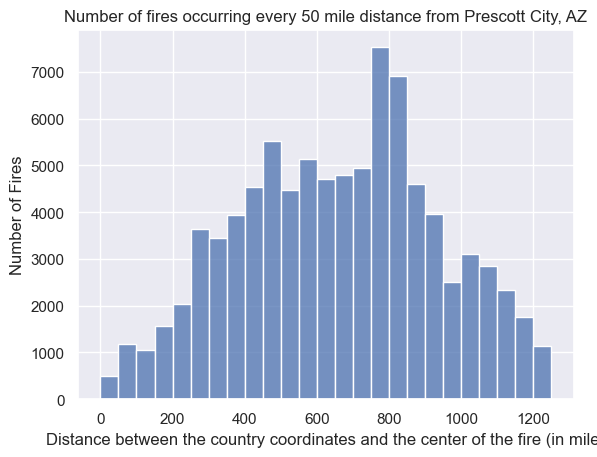

In [66]:
fig = plt.figure()
sns.set(rc={'figure.figsize':(12,8)})

ax = sns.histplot(df, x='Distance_To_County_miles', binrange=(0, 1250), binwidth=50)
ax.set_title("Number of fires occurring every 50 mile distance from Prescott City, AZ")
ax.set(xlabel='Distance between the country coordinates and the center of the fire (in mile)', ylabel='Number of Fires')
fig.savefig('../Results/histogram_fires.png')
print('')

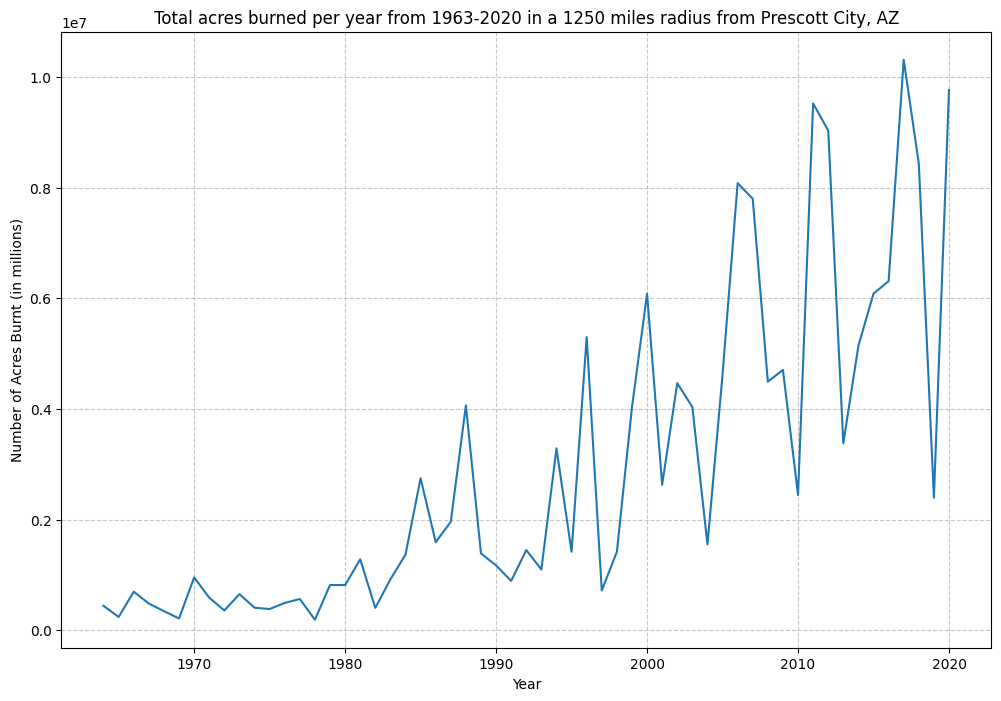

In [57]:
fig = plt.figure()
ax = df.groupby('Fire_Year').GIS_Acres.sum().plot(figsize=(12,8))
ax.set_title("Total acres burned per year from 1963-2020 in a 1250 miles radius from Prescott City, AZ")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Acres Burnt (in millions)")
ax.grid(True, linestyle='--', alpha=0.7)

fig.savefig('../Results/acres_burnt.png')

We notice that the peak of every few years keep on increasing. There are some years where the number of acres burned drops but overall the trend is quite apparent

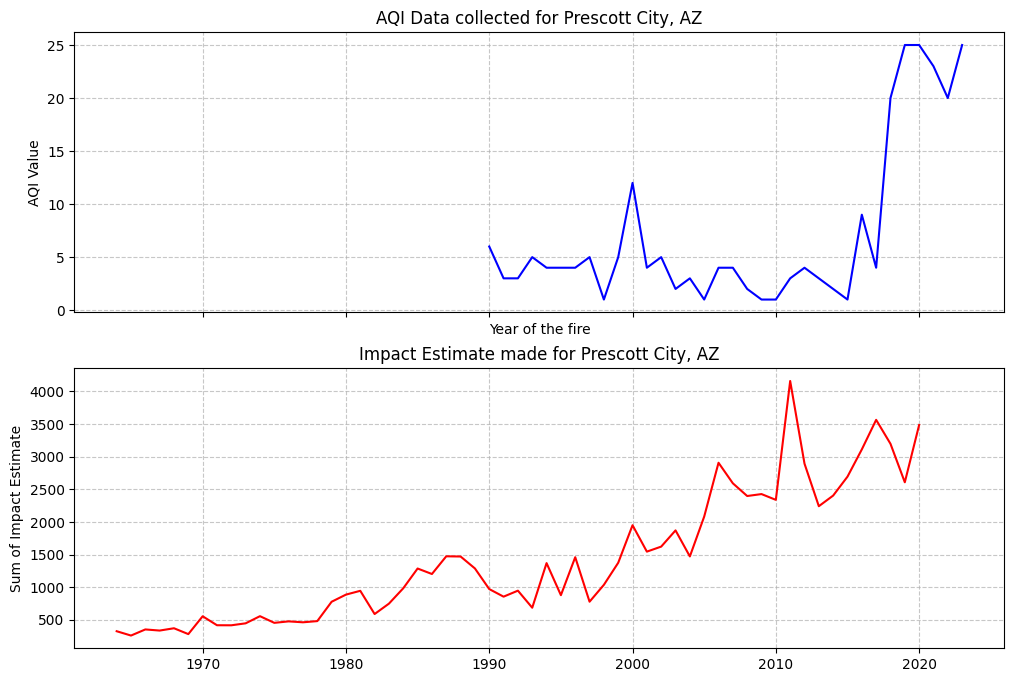

In [56]:
import matplotlib.pyplot as plt
# Create the first plot
# fig, ax1 = plt.subplots()
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Plot the first dataframe on the first y-axis
ax1.plot(df_aqi[['AQI', 'date_year']].groupby('date_year').min(), color='blue', label='AQI Values')
ax1.set_xlabel('Year of the fire')
ax1.set_ylabel('AQI Value')


# Plot the second dataframe on the second y-axis
ax2.plot(df[['Fire_Year', 'impact_estimate']].groupby('Fire_Year').sum(), color='red', label='Impact Estimate')
ax2.set_ylabel('Sum of Impact Estimate')

ax1.grid(True, linestyle='--', alpha=0.7)
ax2.grid(True, linestyle='--', alpha=0.7)

ax1.set_title("AQI Data collected for Prescott City, AZ")
ax2.set_title("Impact Estimate made for Prescott City, AZ")

# Display the plot
plt.show()
fig.savefig('../Results/AQIvsEstimate.png')

Unfortunately, the AQI data is very sparse, and only available from 1990. We must take this data with a grain of salt and not consider it the ground truth right away. Only a few days of data is used to aggregate for one fire season and there is a lot of scope for improvement. While our wildfire estimate does not seems to be similar to the AQI, only an indepth correlation analysis would yeild statistically significant results. 